<a href="https://colab.research.google.com/github/nemanja899/Sunspots-Forecasting/blob/master/Sunspots_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sun_df=pd.read_csv("./drive/MyDrive/ColabNotebooks/Dataset/sunspots/Sunspots.csv",index_col=0,parse_dates=["Date"])

In [ ]:
sun_df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [ ]:
sun_df.columns

Index(['Date', 'Monthly Mean Total Sunspot Number'], dtype='object')

In [ ]:
sun_df=sun_df.rename(columns={"Monthly Mean Total Sunspot Number":"Monthly_Sunspots"})

In [ ]:
sun_df.isna().sum()

Date                0
Monthly_Sunspots    0
dtype: int64

In [ ]:
sun_df = sun_df.set_index("Date").to_period("M")

In [ ]:
sun_df.head()

,Monthly_Sunspots
Date,
1749-01,96.7
1749-02,104.3
1749-03,116.7
1749-04,92.8
1749-05,141.7


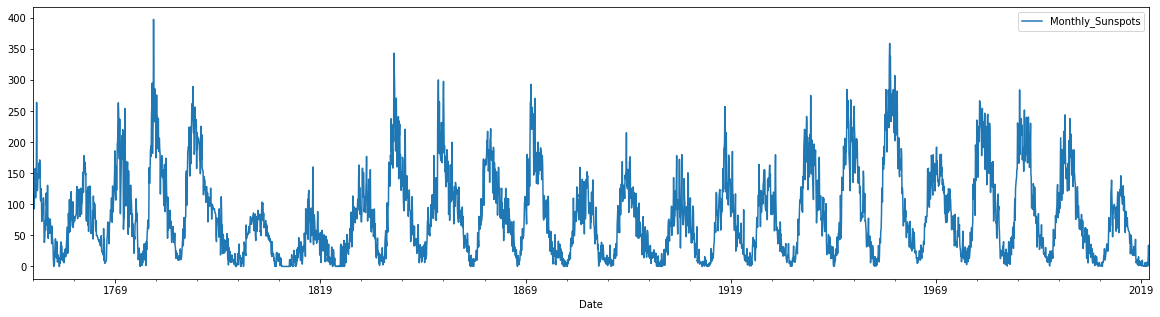

In [ ]:
from IPython.core.pylabtools import figsize
sun_df.plot(figsize=(20,5))

In [ ]:
sun_df.index=sun_df.index.to_timestamp()

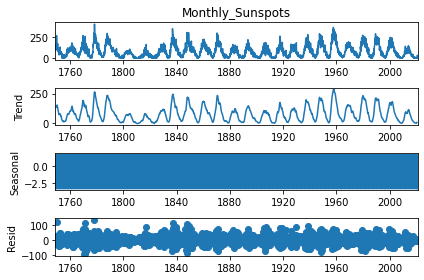

In [ ]:
import statsmodels.api as sm
from pylab import rcParams
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(sun_df.Monthly_Sunspots, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
Y_train=sun_df.loc[:'1969-1']
Y_test=sun_df.loc['1969-2':]

In [ ]:
Y_train.tail()

,Monthly_Sunspots
Date,
1968-09-01,166.0
1968-10-01,152.5
1968-11-01,121.7
1968-12-01,155.5
1969-01-01,147.8


In [ ]:
Y_test.head()

,Monthly_Sunspots
Date,
1969-02-01,170.5
1969-03-01,192.3
1969-04-01,151.1
1969-05-01,169.9
1969-06-01,150.1


In [ ]:
sun_df.shape

(3265, 1)

In [ ]:
Y_train.shape

(2641, 1)

In [ ]:
Y_test.shape

(624, 1)

In [ ]:
def plot_series(true_value, predicted_value, format="-",title=None):
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.plot(true_value['Monthly_Sunspots'], label='True value')
    plt.plot(predicted_value['Monthly_Sunspots'], label='Predicted values')
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

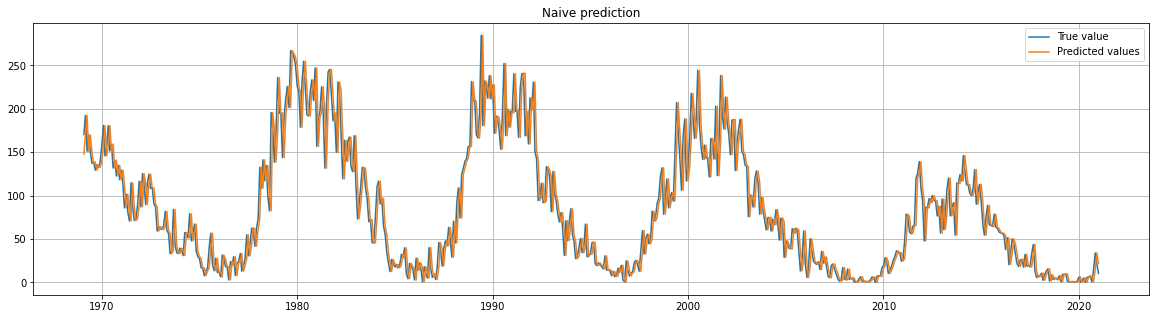

In [ ]:
y_hat_naive=sun_df.loc["1969-01":"2020-12"]
y_hat_naive=y_hat_naive.set_index(Y_test.index)
plot_series(Y_test,y_hat_naive,title="Naive prediction" )


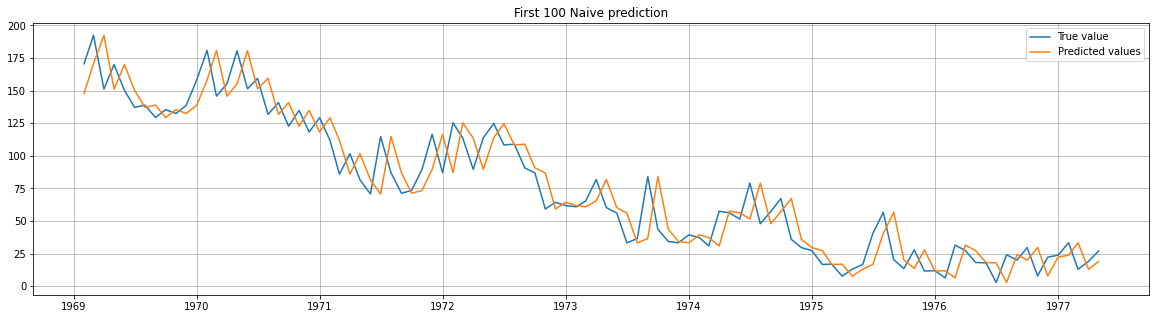

In [ ]:
plot_series(Y_test.iloc[:100],y_hat_naive.iloc[:100],title="First 100 Naive prediction")

In [ ]:
f'true value:{Y_test.Monthly_Sunspots[0]} predicted value: {y_hat_naive.Monthly_Sunspots[0]}'

'true value:170.5 predicted value: 147.8'

In [ ]:
import tensorflow as tf
print(tf.keras.metrics.mean_absolute_error(Y_test.Monthly_Sunspots, y_hat_naive.Monthly_Sunspots).numpy())
print(tf.keras.metrics.mean_squared_error(Y_test.Monthly_Sunspots, y_hat_naive.Monthly_Sunspots).numpy())

17.91730769230769
625.4072115384615


In [ ]:
def moving_average_forecast(series, window_size):
    """Generise MA forcast

    Args:
      series (array of float) - sadrzi podatke serije
      window_size (int) - broj koraka za racunanje

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Inicijalizacija liste
    forecast = []
    
    # Racuna MA u odnosu na velicinu prozora
    for time in range(series.shape[0] - window_size):
      forecast.append(series.Monthly_Sunspots[time:time + window_size].mean())
    
    
    forecast = pd.Series(forecast,index=Y_test.index)

    return forecast

In [ ]:
# Generate the moving average forecast
window=12
mov_avg_df=sun_df.iloc[Y_train.shape[0]-window+1:,:]

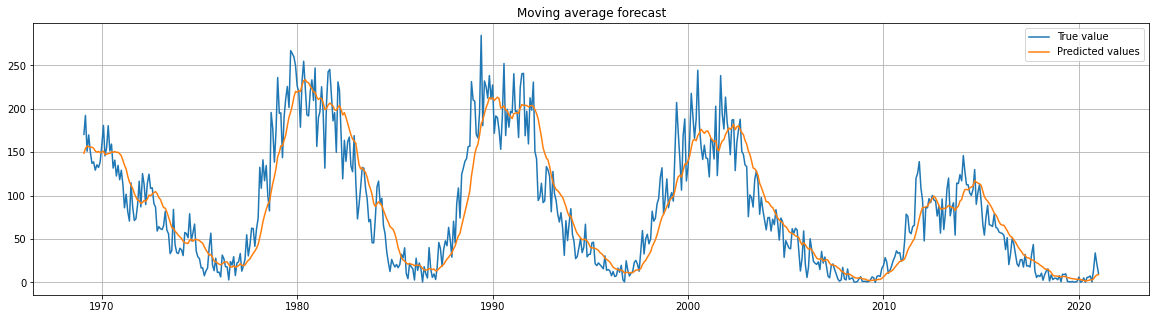

In [ ]:

moving_avg = mov_avg_df.rolling(window=window).mean().dropna()

# Plot the results
plot_series(Y_test,moving_avg,title="Moving average forecast")

In [ ]:
# Compute the metrics
print(tf.keras.metrics.mean_absolute_error(Y_test.Monthly_Sunspots, moving_avg.Monthly_Sunspots).numpy())
print(tf.keras.metrics.mean_squared_error(Y_test.Monthly_Sunspots, moving_avg.Monthly_Sunspots).numpy())

19.781917735042732
726.2107638888889


In [ ]:
sun_df.index.max().year-sun_df.index.min().year


272

In [ ]:
sun_df.index.max()

Timestamp('2021-01-01 00:00:00', freq='MS')

In [ ]:
sun_df.index.min()

Timestamp('1749-01-01 00:00:00', freq='MS')

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("272Y") / pd.Timedelta("30.42D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(20,10))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 8,12.4,16,24.8, 64])
    ax.set_xticklabels(
        [
            "272 years (1)",
            "136 years (2)",
            "68 years (4)",
            "34 years(8)",
            "22 years (12.4)",
            "11 years (24.8)",
            "4 years and 3 months (64)"
            
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


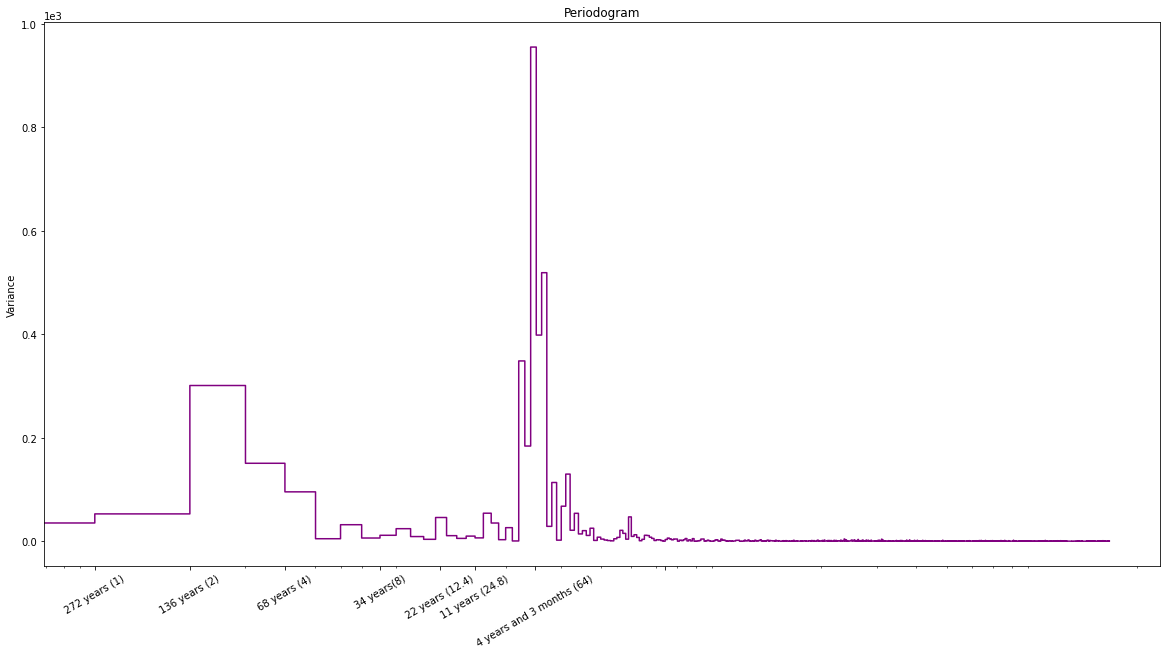

In [ ]:
plot_periodogram(sun_df.Monthly_Sunspots)

In [ ]:
m=12*4+3

In [ ]:
sun_df_diff=sun_df.diff(m)
sun_df_diff.head()

,Monthly_Sunspots
Date,
1749-01-01,NaN
1749-02-01,NaN
1749-03-01,NaN
1749-04-01,NaN
1749-05-01,NaN


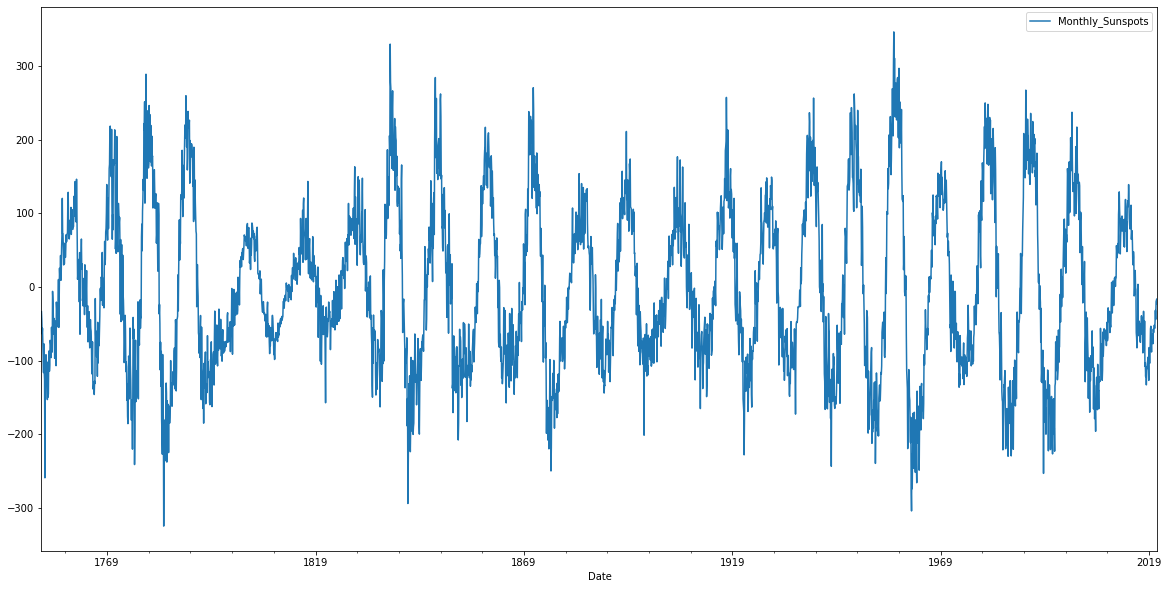

In [ ]:
sun_df_diff.dropna(inplace=True)
sun_df_diff.plot(figsize=(20,10))

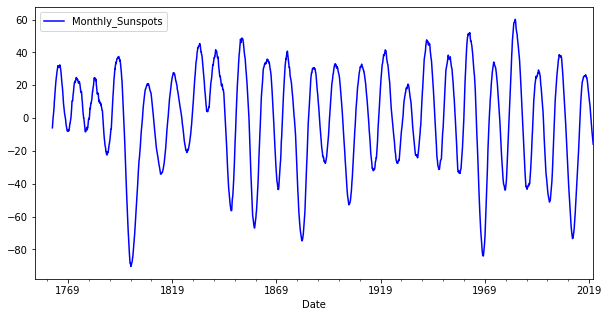

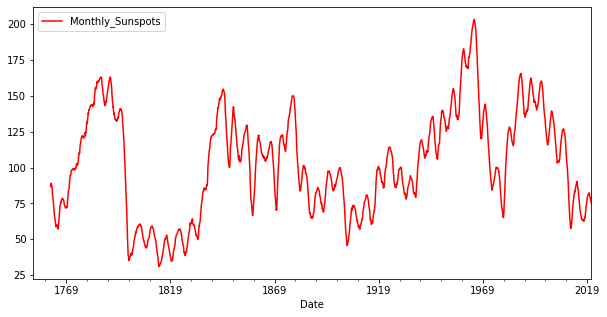

In [ ]:
ns_mean_roll_mean = sun_df_diff.rolling(window=100).mean()
ns_mean_roll_sd = sun_df_diff.rolling(window=100).std()

ns_mean_roll_mean.plot(figsize=(10,5),color='blue')
ns_mean_roll_sd.plot(figsize=(10,5),color='red')

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(sun_spots):
    result=adfuller(sun_spots)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(sun_df_diff.Monthly_Sunspots)

ADF Test Statistic : -14.015985756257447
p-value : 3.642238920704743e-26
#Lags Used : 27
Number of Observations Used : 3186
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


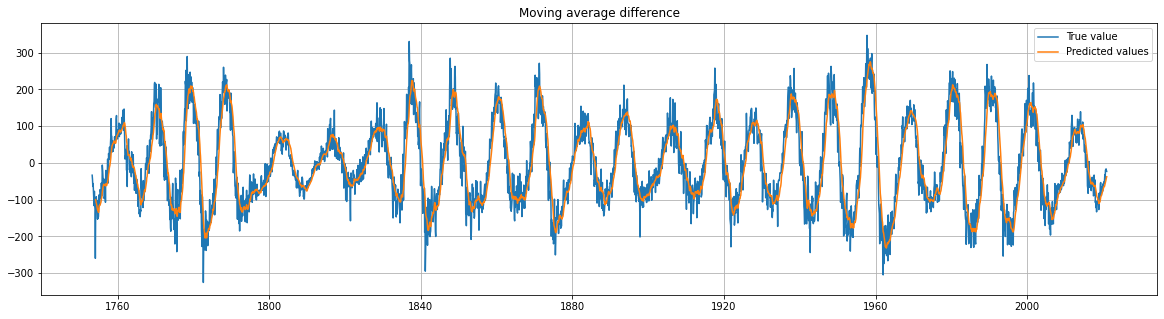

In [ ]:
moving_avg_diff = sun_df_diff.rolling(window=window).mean().dropna()
# Plot the results
plot_series(sun_df_diff,moving_avg_diff,title="Moving average difference")

In [ ]:
moving_avg_diff_pred=moving_avg_diff

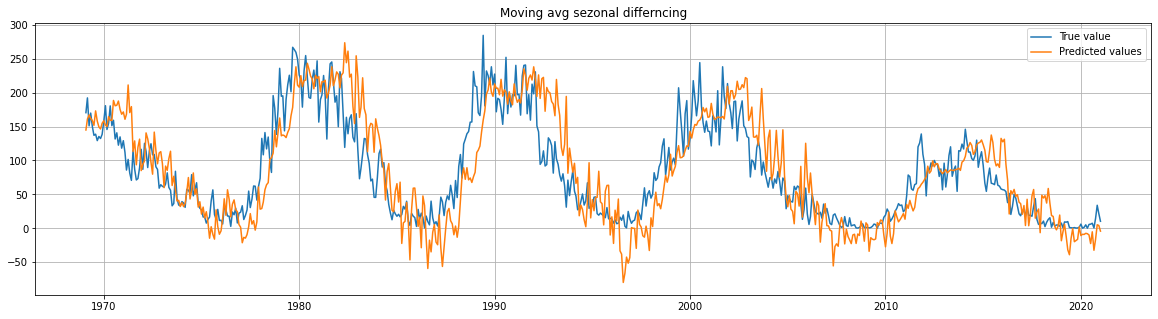

In [ ]:
moving_avg_diff_pred.Monthly_Sunspots=moving_avg_diff.values[:,0]+sun_df.iloc[window-1:-m].values[:,0]
moving_avg_diff_test=moving_avg_diff_pred.iloc[Y_train.shape[0]-window-m+1:]
plot_series(Y_test,moving_avg_diff_test,title="Moving avg sezonal differncing")

In [ ]:
# Compute the metrics
print(tf.keras.metrics.mean_absolute_error(Y_test.Monthly_Sunspots, moving_avg_diff_test.Monthly_Sunspots).numpy())
print(tf.keras.metrics.mean_squared_error(Y_test.Monthly_Sunspots, moving_avg_diff_test.Monthly_Sunspots).numpy())

33.151268696581205
1885.0688547231127


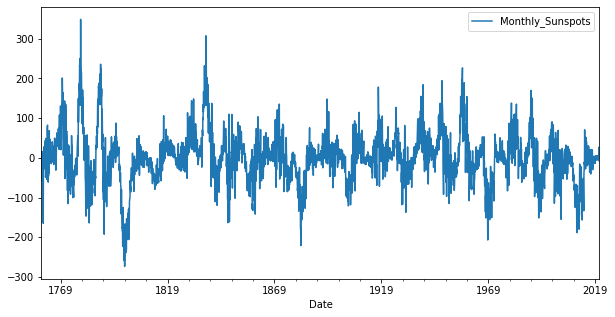

In [ ]:
m2=132
sun_df_diff_11=sun_df.diff(m2)
sun_df_diff_11.dropna(inplace=True)
sun_df_diff_11.plot(figsize=(10,5))

In [ ]:
adfuller_test(sun_df_diff_11.Monthly_Sunspots)

ADF Test Statistic : -8.61268643025613
p-value : 6.412281313196065e-14
#Lags Used : 26
Number of Observations Used : 3106
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


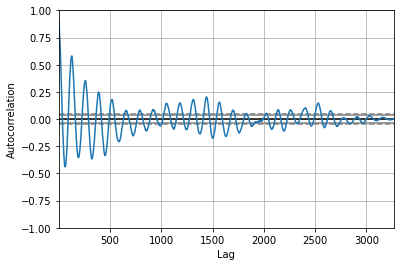

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(sun_df['Monthly_Sunspots'])

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


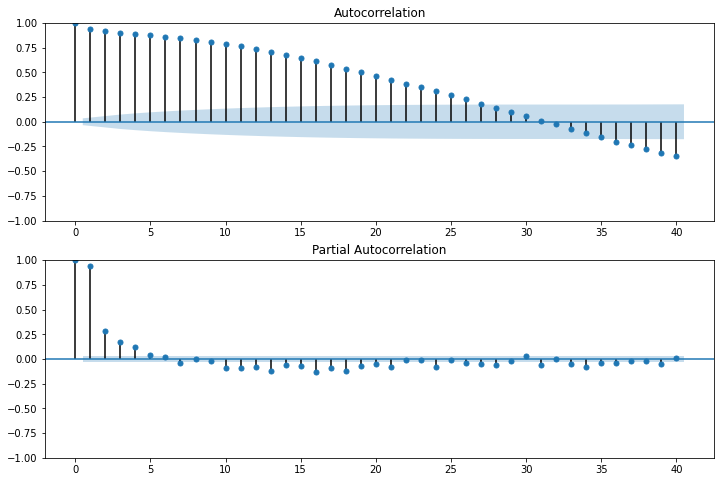

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sun_df_diff.Monthly_Sunspots,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sun_df_diff.Monthly_Sunspots,lags=40,ax=ax2)

In [ ]:
sun_df_diff=sun_df_diff.diff()

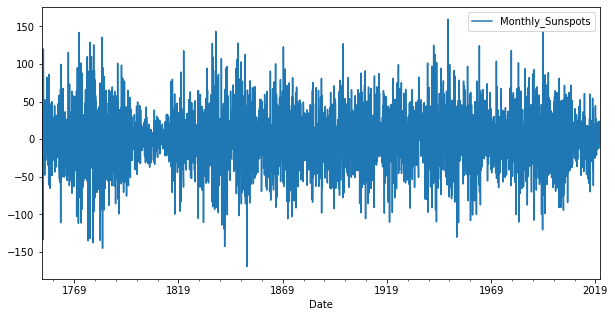

In [ ]:
sun_df_diff.dropna(inplace=True)
sun_df_diff.plot(figsize=(10,5))

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


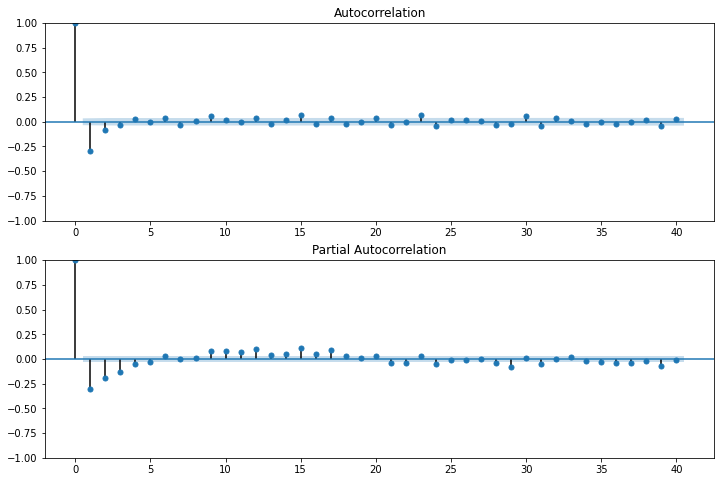

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sun_df_diff.Monthly_Sunspots,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sun_df_diff.Monthly_Sunspots,lags=40,ax=ax2)

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def optimize_SARIMAX(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog,order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
pip install pmdarima

In [ ]:
from pmdarima import auto_arima

In [ ]:
model_autoarima = auto_arima(Y_train.Monthly_Sunspots,start_p=0,start_q=0,d=0,max_p=4,max_q=4,max_d=1,
                             seasonal=True,m=m,start_P=0,start_Q=0,D=0,max_P=4,max_Q=4,max_D=1,information_critiria="AIC")
# Zbog velikog broja m, Izvrsavanje postaje izuzetno zahtevno, zauzimace ogromnu memoriju i prestace sa radom


In [ ]:
from itertools import product
ps = range(0, 5, 1)
d = 0
qs = range(0, 5, 1)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_SARIMAX(order_list, exog=Y_train.Monthly_Sunspots)
result_df

  0%|          | 0/25 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(3, 0, 2)",24563.290473
1,"(2, 0, 4)",24569.720728
2,"(4, 0, 3)",24631.954225
3,"(3, 0, 4)",24638.445032
4,"(1, 0, 2)",24639.807938
5,"(4, 0, 1)",24640.264253
6,"(1, 0, 4)",24640.549515
7,"(3, 0, 1)",24640.720695
8,"(1, 0, 3)",24641.623455
9,"(2, 0, 2)",24641.697697


In [ ]:
p=3
d=0
q=2
best_model=sm.tsa.statespace.SARIMAX(Y_train.Monthly_Sunspots,order=(p, d, q),seasonal_order=(3,0,2,m2)) #ili m, m2=132 , m=51
results=best_model.fit()
#print(best_model.summary())
# ZBog ogromnog m RAM memorija se brzo puni. Preporucuje se da se predvidjanje radi uz pomoc neuronskih mreza , a ne SARIMAX-a

In [ ]:
ljung_box, p_value = acorr_ljungbox(best_model.resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

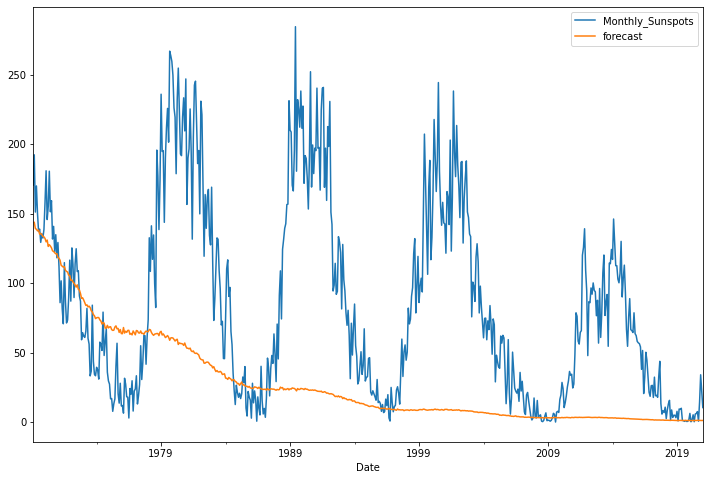

In [ ]:
Y_test['forecast']=results.predict(start=Y_train.shape[0]+1,end=sun_df.shape[0],dynamic=True)
Y_test[['Monthly_Sunspots','forecast']].plot(figsize=(12,8))

In [ ]:
# Compute the metrics
print(tf.keras.metrics.mean_absolute_error(Y_test.Monthly_Sunspots, Y_test.forecast).numpy())
print(tf.keras.metrics.mean_squared_error(Y_test.Monthly_Sunspots, Y_test.forecast).numpy())

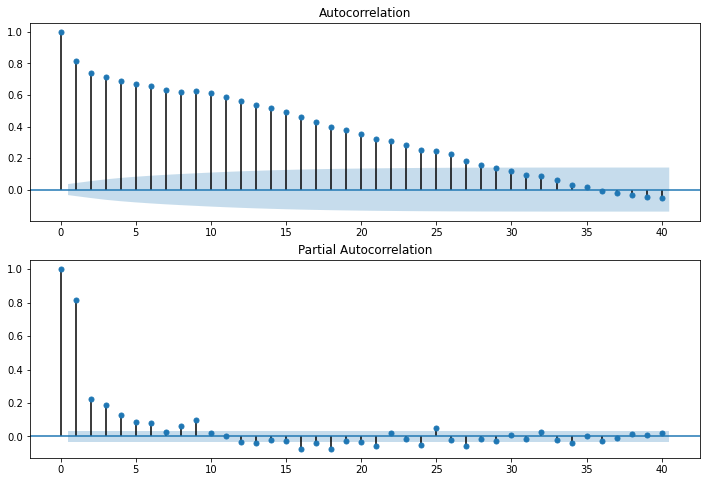

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sun_df_diff_11.Monthly_Sunspots,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sun_df_diff_11.Monthly_Sunspots,lags=40,ax=ax2)

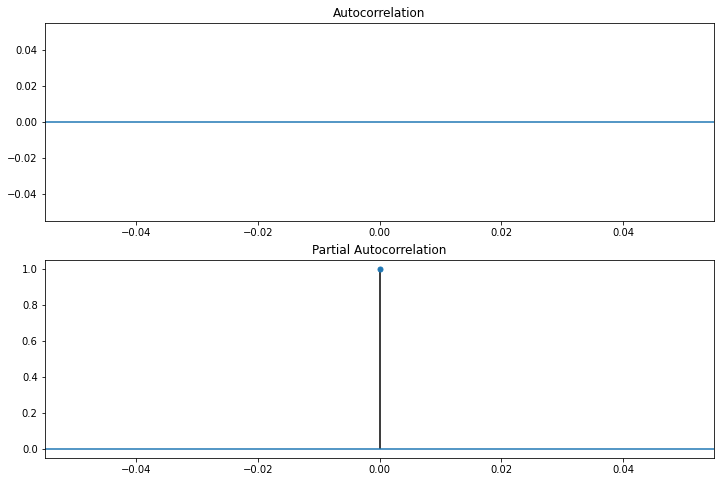

In [ ]:
sun_df_diff_11=sun_df_diff_11.diff()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sun_df_diff_11.Monthly_Sunspots,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sun_df_diff_11.Monthly_Sunspots,lags=40,ax=ax2)

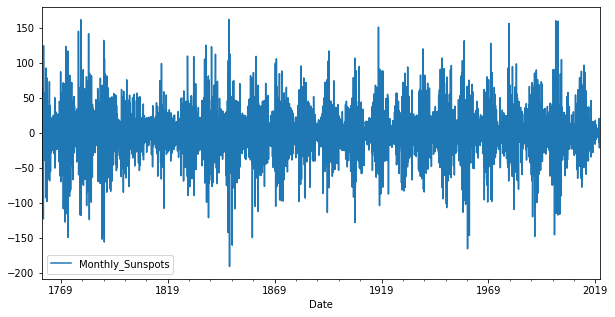

In [ ]:
sun_df_diff_11.plot(figsize=(10,5))